![alt text](https://upload.wikimedia.org/wikipedia/commons/2/22/ENSAE_logo_developpe.jpg)

# Naive Bayes for Text Classification

When working with text data, we are often faced with a **large number of features**. In fact, **Bag of Words** - which is the usual method by which text is transformed into numerical features - consists of transforming each text into a list of **word occurences** for an often very large set of words called the **vocabulary**. Thankfully, there are algorithms that can cope with such a high number of features : **Naive Bayes** classifiers.  

To illustrate the ability of Naive Bayes to perform on a large set of features, we will use it on the **Sentiment Analysis** task associated with **IMDB Movie Reviews dataset**.

## IMDB dataset

To get the IMDB Movie Reviews dataset we will need to download a zip file containing many reviews (each one in a single file, dispatched in two folders : one for training, the other for testing). The dataset is available at : http://ai.stanford.edu/~amaas/data/sentiment/  

Once downloaded we can load the datasets into 2 pandas dataframes using :

In [1]:
import os
import numpy as np
import pandas as pd


def load_train_test_imdb_data(data_dir):
    """Loads the IMDB train/test datasets from a folder path.
    Input:
    data_dir: path to the "aclImdb" folder.
    
    Returns:
    train/test datasets as pandas dataframes.
    """

    data = {}
    for split in ["train", "test"]:
        data[split] = []
        for sentiment in ["neg", "pos"]:
            score = 1 if sentiment == "pos" else 0

            path = os.path.join(data_dir, split, sentiment)
            file_names = os.listdir(path)
            for f_name in file_names:
                with open(os.path.join(path, f_name), "r") as f:
                    review = f.read()
                    data[split].append([review, score])

    # shuffling the data after mapping the reviews to their scores
    np.random.shuffle(data["train"])        
    data["train"] = pd.DataFrame(data["train"], columns=['text', 'sentiment'])

    np.random.shuffle(data["test"])
    data["test"] = pd.DataFrame(data["test"], columns=['text', 'sentiment'])

    return data["train"], data["test"]

In [2]:
data_dir = "aclImdb/"
training_data, test_data = load_train_test_imdb_data(data_dir)

Let's look at a sample of our data :

In [3]:
training_data.head()

,text,sentiment
0,This is a very rare film and probably the leas...,1
1,This was what black society was like before th...,1
2,"If this is someone's ""favorite"" movie, they ne...",0
3,After a brief prologue showing a masked man st...,1
4,Had this been the original 1914 version of TES...,1


We can also check for class imbalance :

In [4]:
print(f"Frequency of positive texts in the training set: {np.mean(training_data['sentiment'])}")
print(f"Frequency of positive texts in the test set: {np.mean(test_data['sentiment'])}")

Frequency of positive texts in the training set: 0.5
Frequency of positive texts in the test set: 0.5


We see that the training/test datasets are perfectly balanced as we would want ideally.

## Pre-processing

Textual data is often messy, therefore we need to clean it a bit to ensure that the words "the", "The" and "the," are considered as a single word. To do that, we use the following function that removes any punctuation and HTML tags then changes everything into lowercase :

In [5]:
import re


def clean_text(text):
    """Applies some pre-processing on the given text
    then splits it, resulting in a word sequence.
    
    Steps :
    - Removing HTML tags
    - Removing punctuation
    - Lowering text
    """

    text = str(text)
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags if any

    # remove punctuation
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    
    # lower text
    text = text.lower()

    return text

In [8]:
random_text = np.random.choice(training_data["text"].values)
print(random_text)
print()
print(clean_text(random_text))

I can't believe I am just now seeing this film -- I think perhaps I thought it was another movie about slaves being mistreated, and I avoided Roots for the same reason -- just as I have yet to see Schindler's List -- I don't want to be "entertained" by other peoples' pain, not matter how authentic or informative it is supposed to be.<br /><br />So I guess the main thing I noticed about The Color Purple was that it was not about black people being mistreated by whites. The black people were perfectly capable of raping their own daughters -- or giving them away to be treated as slaves by their "husbands". It was painful to watch, but everyone redeemed himself in the end, and the acting was phenomenal! I couldn't believe the character Oprah played at the age of 35! And I adore Whoopi to start with - she was amazing. I'm so glad I was feeling lousy yesterday afternoon and Showtime was running The Color Purple.

i can t believe i am just now seeing this film    i think perhaps i thought it 

We can now simply split the cleaned text by spaces to get word sequences.  

For example, this can be used to compute the average text length (in words) :

In [9]:
word_sequences = map(lambda s: clean_text(s).split(), training_data["text"].values)
sequence_lengths = map(len, word_sequences)

print(f"Average text length in training dataset: {np.mean(list(sequence_lengths))} words") 

Average text length in training dataset: 238.18524 words


## Benchmarks

We can now do many benchmarks using not only the usual Bag of Words, but also using Term Frequency (TF) or TF-IDF.

We will also be comparing two Naive Bayes algorithms (the multinomial and the binomial) with SVM and Logistic Regression.

In [7]:
import time
import pickle
from collections import defaultdict

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import accuracy_score, classification_report

from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [8]:
def benchmark(model, X_train, y_train, X_test, y_test):
    """
    Benchmarks a model by computing the training time, the prediction
    time and some other metrics.
    """
    
    print("Model:", model[0])

    print()

    # Training step
    t = time.time()
    model[1].fit(X_train, y_train)
    train_time = time.time() - t
    print("Training Time: {:.2f}s".format(train_time))
    
    # Prediction step
    t = time.time()
    y_pred = model[1].predict(X_test)
    pred_time = time.time() - t
    print("Prediction Time: {:.2f}s".format(pred_time))
    
    print()

    # Evaluation step
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy: {:.2f}".format(acc))
    
    print()

    print(classification_report(
        y_test, y_pred,
        labels=[0, 1], target_names=["negative", "positive"]))
    
    print("\n===============\n")
    
    return model[0], train_time, pred_time, acc

## Count Vectorizer

In [16]:
results = defaultdict(list)

for i in range(4):

    ngram_range = (1, 1 + i)
    
    print("Benchmarks with n-gram range:", ngram_range)
    print("====================================")
    print("====================================")

    # Transform each text into a vector of word counts
    vectorizer = CountVectorizer(stop_words="english",
                                 preprocessor=clean_text,
                                 ngram_range=ngram_range)

    training_features = vectorizer.fit_transform(training_data["text"])    
    test_features = vectorizer.transform(test_data["text"])

    print()
    print(f"Number of features: {training_features.shape[1]}")
    print()
    
    # List of models to becnhmark
    models = {
        "Bernoulli NB": BernoulliNB(),
        "Multinomial NB": MultinomialNB(),
        "Logistic Regression": LogisticRegression(),
        "Linear SVM": LinearSVC()
    }

    print("Performance on the IMDB dataset:\n================================\n")

    for model in models.items():

        results[i].append(benchmark(
            model,
            training_features, training_data["sentiment"],
            test_features, test_data["sentiment"]
        ))


Benchmarks with n-gram range: (1, 1)

Number of features: 75449

Performance on the IMDB dataset:

Model: Bernoulli NB

Training Time: 0.10s
Prediction Time: 0.07s

Accuracy: 0.81

             precision    recall  f1-score   support

   negative       0.77      0.89      0.83     12500
   positive       0.87      0.74      0.80     12500

avg / total       0.82      0.81      0.81     25000



Model: Multinomial NB

Training Time: 0.05s
Prediction Time: 0.03s

Accuracy: 0.82

             precision    recall  f1-score   support

   negative       0.79      0.88      0.83     12500
   positive       0.86      0.76      0.81     12500

avg / total       0.82      0.82      0.82     25000



Model: Logistic Regression

Training Time: 5.34s
Prediction Time: 0.02s

Accuracy: 0.86

             precision    recall  f1-score   support

   negative       0.85      0.87      0.86     12500
   positive       0.87      0.85      0.86     12500

avg / total       0.86      0.86      0.86     2500

In [17]:
#with open("results_count.pkl", 'wb') as f:
#    pickle.dump(results, f)

## TF

In [11]:
results = defaultdict(list)

for i in range(4):

    ngram_range = (1, 1 + i)
    
    print("Benchmarks with n-gram range:", ngram_range)
    print("====================================")
    print("====================================")

    # Transform each text into a vector of word counts
    vectorizer = TfidfVectorizer(stop_words="english",
                                 preprocessor=clean_text,
                                 ngram_range=ngram_range, use_idf=False)

    training_features = vectorizer.fit_transform(training_data["text"])    
    test_features = vectorizer.transform(test_data["text"])

    print()
    print(f"Number of features: {training_features.shape[1]}")
    print()
    
    # List of models to becnhmark
    models = {
        "Bernoulli NB": BernoulliNB(),
        "Multinomial NB": MultinomialNB(),
        "Logistic Regression": LogisticRegression(),
        "Linear SVM": LinearSVC()
    }

    print("Performance on the IMDB dataset:\n================================\n")

    for model in models.items():

        results[i].append(benchmark(
            model,
            training_features, training_data["sentiment"],
            test_features, test_data["sentiment"]
        ))


Benchmarks with n-gram range: (1, 1)

Number of features: 75449

Performance on the IMDB dataset:

Model: Bernoulli NB

Training Time: 0.05s
Prediction Time: 0.04s

Accuracy: 0.81

             precision    recall  f1-score   support

   negative       0.77      0.89      0.83     12500
   positive       0.87      0.74      0.80     12500

avg / total       0.82      0.81      0.81     25000



Model: Multinomial NB

Training Time: 0.02s
Prediction Time: 0.01s

Accuracy: 0.84

             precision    recall  f1-score   support

   negative       0.82      0.88      0.85     12500
   positive       0.87      0.80      0.84     12500

avg / total       0.84      0.84      0.84     25000



Model: Logistic Regression

Training Time: 1.21s
Prediction Time: 0.01s

Accuracy: 0.87

             precision    recall  f1-score   support

   negative       0.88      0.87      0.87     12500
   positive       0.87      0.88      0.87     12500

avg / total       0.87      0.87      0.87     2500

In [12]:
#with open("results_tf.pkl", 'wb') as f:
#    pickle.dump(results, f)

## TF-IDF

In [13]:
results = defaultdict(list)

for i in range(4):

    ngram_range = (1, 1 + i)
    
    print("Benchmarks with n-gram range:", ngram_range)
    print("====================================")
    print("====================================")

    # Transform each text into a vector of word counts
    vectorizer = TfidfVectorizer(stop_words="english",
                                 preprocessor=clean_text,
                                 ngram_range=ngram_range)

    training_features = vectorizer.fit_transform(training_data["text"])    
    test_features = vectorizer.transform(test_data["text"])

    print()
    print(f"Number of features: {training_features.shape[1]}")
    print()
    
    # List of models to becnhmark
    models = {
        "Bernoulli NB": BernoulliNB(),
        "Multinomial NB": MultinomialNB(),
        "Logistic Regression": LogisticRegression(),
        "Linear SVM": LinearSVC()
    }

    print("Performance on the IMDB dataset:\n================================\n")

    for model in models.items():

        results[i].append(benchmark(
            model,
            training_features, training_data["sentiment"],
            test_features, test_data["sentiment"]
        ))


Benchmarks with n-gram range: (1, 1)

Number of features: 75449

Performance on the IMDB dataset:

Model: Bernoulli NB

Training Time: 0.06s
Prediction Time: 0.05s

Accuracy: 0.81

             precision    recall  f1-score   support

   negative       0.77      0.89      0.83     12500
   positive       0.87      0.74      0.80     12500

avg / total       0.82      0.81      0.81     25000



Model: Multinomial NB

Training Time: 0.03s
Prediction Time: 0.02s

Accuracy: 0.83

             precision    recall  f1-score   support

   negative       0.80      0.88      0.84     12500
   positive       0.86      0.78      0.82     12500

avg / total       0.83      0.83      0.83     25000



Model: Logistic Regression

Training Time: 1.01s
Prediction Time: 0.01s

Accuracy: 0.88

             precision    recall  f1-score   support

   negative       0.88      0.88      0.88     12500
   positive       0.88      0.88      0.88     12500

avg / total       0.88      0.88      0.88     2500

In [14]:
#with open("results_tfidf.pkl", 'wb') as f:
#    pickle.dump(results, f)

## Visualization & Results

results_count.pkl



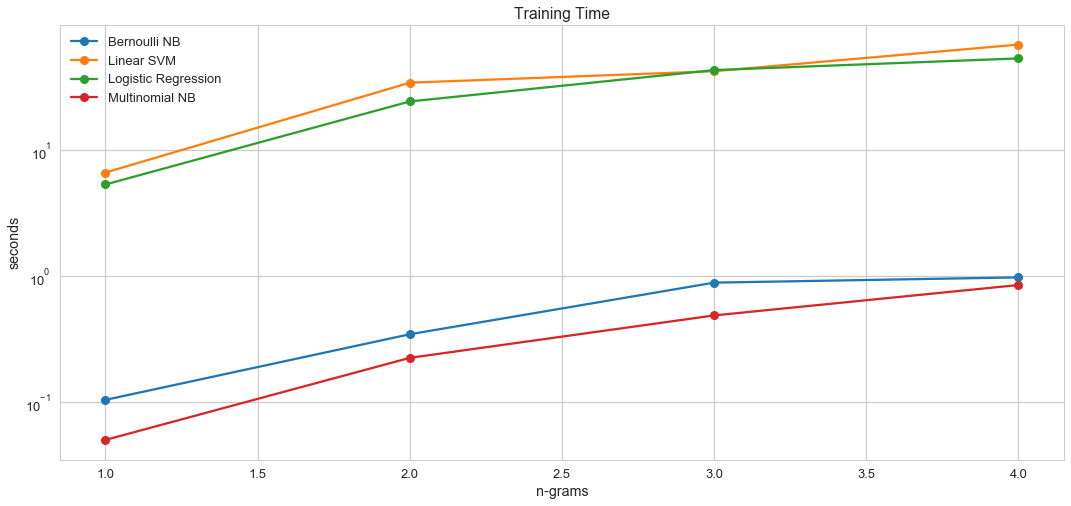

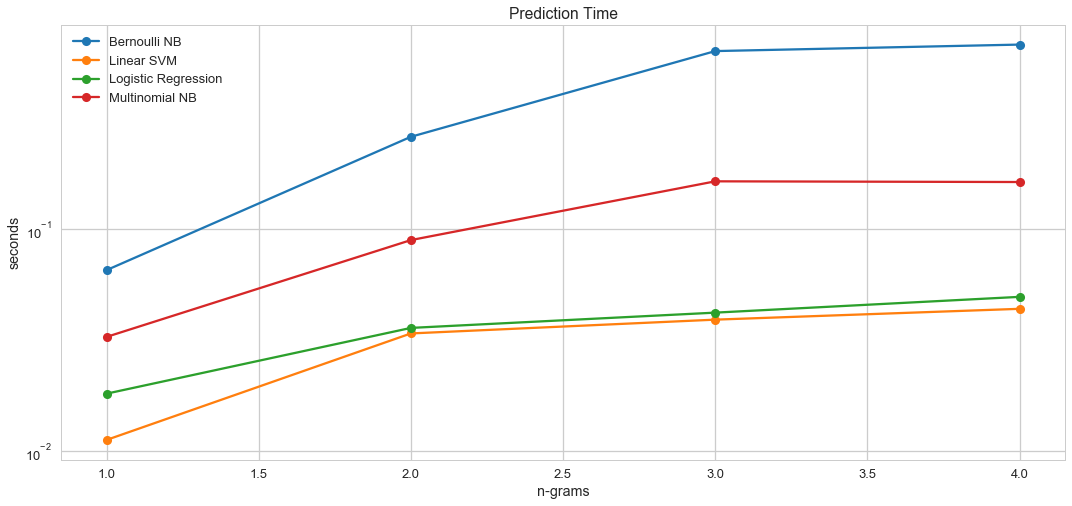

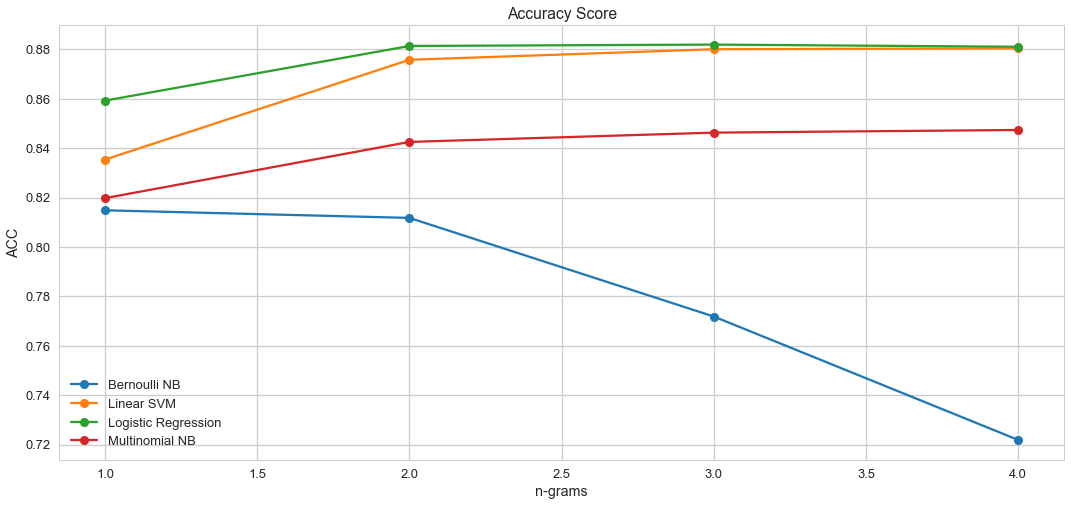

results_tf.pkl



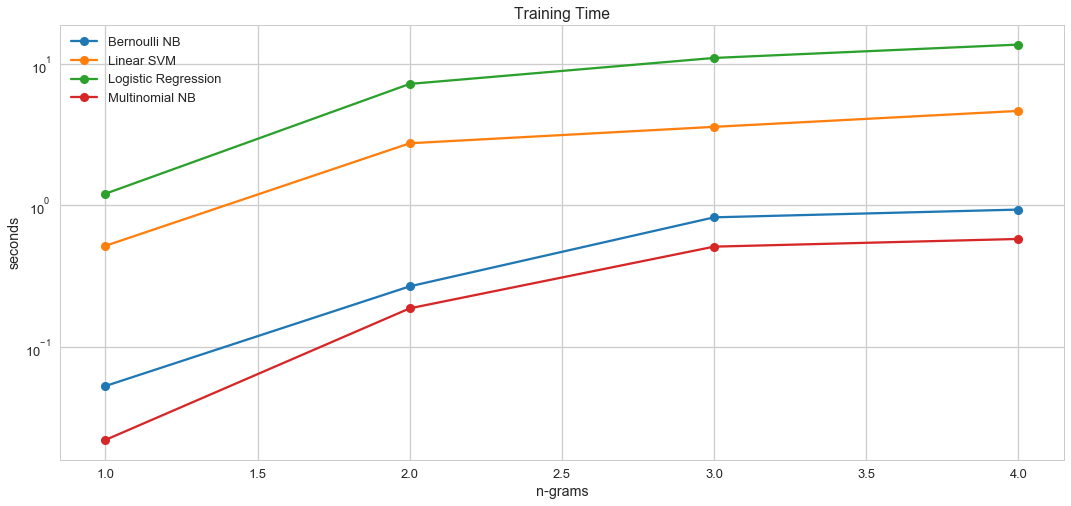

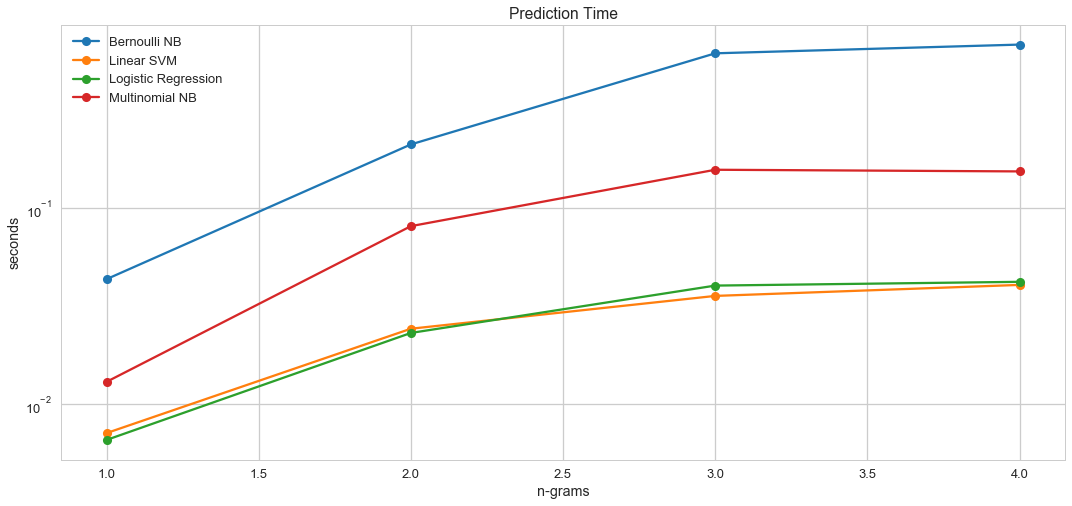

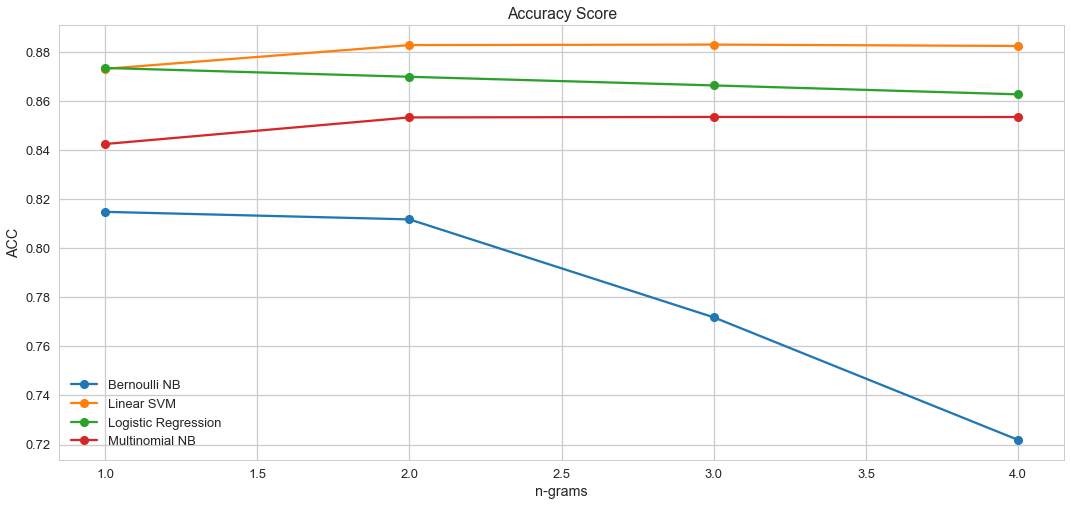

results_tfidf.pkl



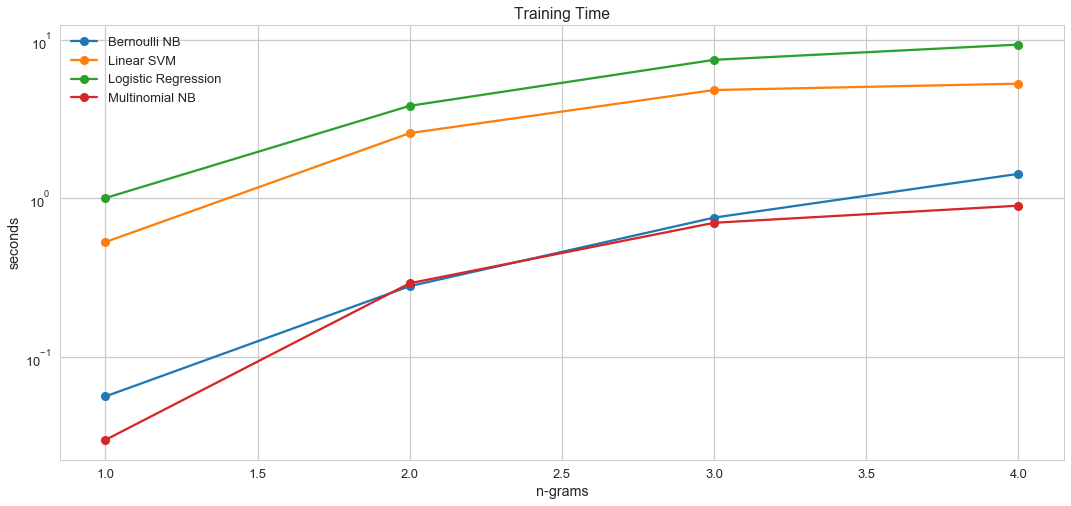

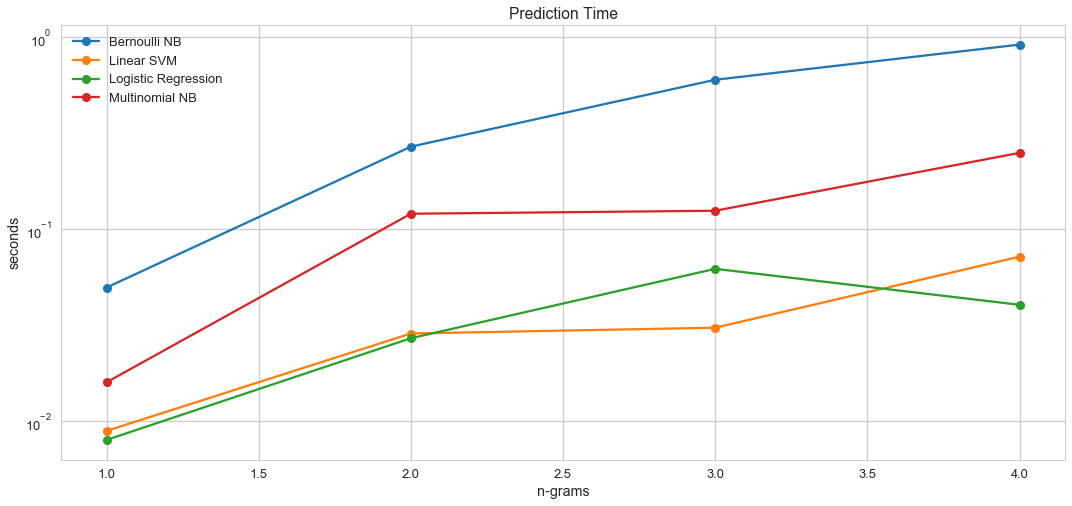

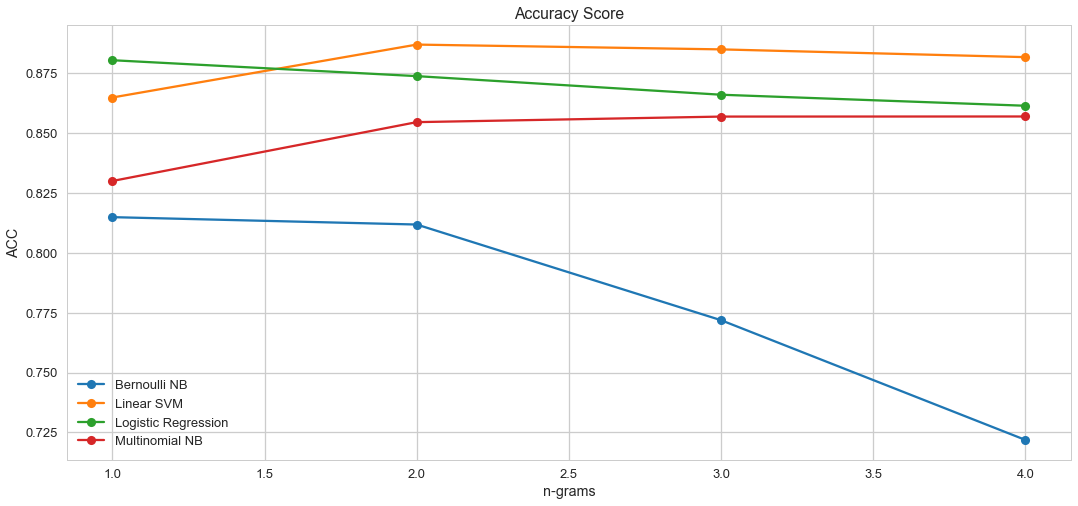

In [89]:
import seaborn as sns
from matplotlib import pylab as plt

sns.set_context("talk")
sns.set_style("whitegrid")
%matplotlib inline


for file in ["results_count.pkl", "results_tf.pkl", "results_tfidf.pkl"]:

    print(file)
    print("============\n")
    
    results_per_ngram = pickle.load(open(file, "rb"))
    
    kind_is_count = (file=="results_count.pkl")
    
    train_time = defaultdict(list)
    pred_time = defaultdict(list)
    acc_score = defaultdict(list)

    for results in results_per_ngram.values():
        for model_results in results:
            name = model_results[0]
            train_time[name].append(model_results[1])
            pred_time[name].append(model_results[2])
            acc_score[name].append(model_results[3])
            
    pd.DataFrame(train_time, index=[1, 2, 3, 4]).plot(figsize=(18, 8),
                                                      logy=True, marker="o")
    plt.title("Training Time")
    plt.ylabel("seconds")
    plt.xlabel("n-grams")
    if kind_is_count:
        plt.savefig(f"training_time_ngrams.png")
    plt.show()
    
    pd.DataFrame(pred_time, index=[1, 2, 3, 4]).plot(figsize=(18, 8),
                                                     logy=True, marker="o")
    plt.title("Prediction Time")
    plt.ylabel("seconds")
    plt.xlabel("n-grams")
    if kind_is_count:
        plt.savefig(f"prediction_time_ngrams.png")
    plt.show()
    
    pd.DataFrame(acc_score, index=[1, 2, 3, 4]).plot(figsize=(18, 8),
                                                     marker="o")
    plt.title("Accuracy Score")
    plt.ylabel("ACC")
    plt.xlabel("n-grams")
    if kind_is_count:
        plt.savefig(f"accuracy_ngrams.png")
    plt.show()

---

---

## Feature importance

We can compute which words are the most important (i.e. most used to differenciate between a positive and a negative sentence) for each model using :

In [26]:
def print_top_bottom(vectorizer, clf, n=10):
    """Prints features with the highest/lowest coefficient values"""

    feature_names = vectorizer.get_feature_names()
    
    if hasattr(clf, "feature_log_prob_"):
        coef = clf.feature_log_prob_
        coef = coef[1] - coef[0]
    else:
        coef = clf.coef_[0]

    top10 = np.argsort(coef)[-n:][::-1]
    bottom10 = np.argsort(coef)[:n]

    print()
    print("positive: %s" % (" | ".join(feature_names[j] for j in top10)))
    print()
    print("negative: %s" % (" | ".join(feature_names[j] for j in bottom10)))

### Example : TF-IDF + Bi-grams

In [30]:
ngram_range = (1, 2)

print("Benchmarks with n-gram range:", ngram_range)
print("====================================")
print("====================================")

# Transform each text into a vector of word counts
vectorizer = TfidfVectorizer(stop_words="english",
                             preprocessor=clean_text,
                             ngram_range=ngram_range)

training_features = vectorizer.fit_transform(training_data["text"])    
test_features = vectorizer.transform(test_data["text"])

print()
print(f"Number of features: {training_features.shape[1]}")
print()

# List of models to becnhmark
models = {
    "Bernoulli NB": BernoulliNB(),
    "Multinomial NB": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Linear SVM": LinearSVC()
}

print("Performance on the IMDB dataset:\n================================\n")

for model in models.items():

    results[i].append(benchmark(
        model,
        training_features, training_data["sentiment"],
        test_features, test_data["sentiment"]
    ))


Benchmarks with n-gram range: (1, 2)

Number of features: 1773605

Performance on the IMDB dataset:

Model: Bernoulli NB

Training Time: 0.24s
Prediction Time: 0.23s

Accuracy: 0.81

             precision    recall  f1-score   support

   negative       0.75      0.94      0.83     12500
   positive       0.91      0.69      0.79     12500

avg / total       0.83      0.81      0.81     25000



Model: Multinomial NB

Training Time: 0.20s
Prediction Time: 0.10s

Accuracy: 0.85

             precision    recall  f1-score   support

   negative       0.83      0.88      0.86     12500
   positive       0.88      0.82      0.85     12500

avg / total       0.86      0.85      0.85     25000



Model: Logistic Regression

Training Time: 4.10s
Prediction Time: 0.02s

Accuracy: 0.87

             precision    recall  f1-score   support

   negative       0.88      0.87      0.87     12500
   positive       0.87      0.88      0.87     12500

avg / total       0.87      0.87      0.87     25

In [31]:
for model in models.items():
    print(model[0], '\n===============')
    print_top_bottom(vectorizer, model[1], n=50)
    print()

Bernoulli NB 

positive: edie | emily blunt | just wonderful | thelma ritter | din | rita hayworth | forbidden planet | mcintire | antwone | excellent script | gunga din | just brilliant | tsui | gunga | cast excellent | doubt best | prince albert | visconti | truly amazing | sabu | goldsworthy | queen victoria | truman capote | quibble | joss | definitely watch | touching story | south street | tsui hark | young victoria | john mcintire | world cup | highly recommended | movie touching | panahi | chris cooper | best documentary | rupert friend | deathtrap | kipling | story beautiful | versatility | antwone fisher | excellently | rings twice | red sox | red rock | pushing daisies | lady shanghai | sam jaffe

negative: acting horrible | hours life | acting awful | worst films | easily worst | avoid like | avoid costs | worst movies | save money | acting atrocious | excuse movie | read script | piece crap | prom night | doubt worst | boll | supposed comedy | worst film | total waste | uw